<a href="https://colab.research.google.com/gist/barronh/84d67cdb426471d5b3207eb020fb5157/cmaq_ozone_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMAQ Ozone Evaluation and Animation with Jupyter

    author: Barron H. Henderson
    date: 2020-05-27
    
* Use jupyter to evaluate publicly avaialble CMAQ Ozone (or your own)
* Outputs:
  * Monthly box plots of model and obs for each region
  * Scatter density plots (model by obs) for each region for each season
  * Map figures or animations of model concentrations
  * Time series plots for individual monitors
* How to:
  * Click "Runtime" and choose "Run all"
  * Skip to "Outputs and User Choices" section

# Preparing System

## Mapping and IOAPI Libraries

* The three commands below install Geographic support (`libgeos-dev`)
* A python library for mapping (`basemap`)
* A python library for IOAPI-metadata support

In [ ]:
# Install basemap using pip
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install https://github.com/barronh/pseudonetcdf/archive/master.zip

## Import Some Useful Libraries

The next code cell imports libraries. If you get an error, likely a library is missing. See Mapping and IOAPI libraries.

* `matplotlib` for plotting
* `numpy` for math
* `pandas` for reading tabular data and dates
* `scipy` for science!
* `PseudoNetCDF` for IOAPI-metadata support
* Set default earth radius to WRF

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import numpy as np
import scipy.stats as stats
import scipy.stats.mstats as mstats
import pandas as pd
import PseudoNetCDF as pnc
from urllib.request import urlretrieve
os.environ['IOAPI_ISPH'] = '6370000.'

# Acquire Data

## Downloading Model File

* There are lots of ways to download.
* The gdown script automates download confirmations via Google Drive
* The faster maybe harder way is with Google Drive and symbolic linking
* The custom way is to upload your own

# gdown is a good method for public from CMAS dataverse

*See https://dataverse.unc.edu/dataverse/cmascenter for other datasets

1. Set input url and model path
2. Download the Google Download Link
3. Download the file
4. Doesn't always work when "Too many users have viewed or downloaded this file recently"

```
cmaqurl = 'https://drive.google.com/file/d/1R988xO7uKInEwiI-AtwNbxPVcd7l1nHx'
modpath = 'DAILY_ACONC_LST_CMAQv5.2_cb6r3_WRF3.8.1_EMP2014fb_2014.nc'
urlretrieve('https://raw.githubusercontent.com/circulosmeos/gdown.pl/master/gdown.pl', 'gdown.pl')
!perl gdown.pl {cmaqurl} {modpath}
```


# EPA serve has Sometimes Google Gets Overwhelmed

* Using EPA ftp server
* Slower, but less likely to fail because of many users
* Copied dataset from Google Drive with O3_MDA8 only


In [2]:
modpath = 'DAILY_ACONC_LST_CMAQv5.2_cb6r3_WRF3.8.1_EMP2014fb_2014.nc'
!wget -O {modpath} --continue ftp://newftp.epa.gov/Air/aqmg/global/tutorial/{modpath}

--2020-06-23 10:30:50--  ftp://newftp.epa.gov/Air/aqmg/global/tutorial/DAILY_ACONC_LST_CMAQv5.2_cb6r3_WRF3.8.1_EMP2014fb_2014.nc
           => 'DAILY_ACONC_LST_CMAQv5.2_cb6r3_WRF3.8.1_EMP2014fb_2014.nc'
Resolving newftp.epa.gov (newftp.epa.gov)... 134.67.100.58
Connecting to newftp.epa.gov (newftp.epa.gov)|134.67.100.58|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Air/aqmg/global/tutorial ... done.
==> SIZE DAILY_ACONC_LST_CMAQv5.2_cb6r3_WRF3.8.1_EMP2014fb_2014.nc ... 200385968
==> PASV ... done.    ==> RETR DAILY_ACONC_LST_CMAQv5.2_cb6r3_WRF3.8.1_EMP2014fb_2014.nc ... done.
Length: 200385968 (191M) (unauthoritative)

100%[======================================>] 200,385,968 11.6MB/s   in 17s    

2020-06-23 10:31:07 (11.3 MB/s) - 'DAILY_ACONC_LST_CMAQv5.2_cb6r3_WRF3.8.1_EMP2014fb_2014.nc' saved [200385968]



## Open the Model file

* Use `PseudoNetCDF` (hereafter `pnc`) to open it.

In [3]:
modf = pnc.pncopen(modpath, format='ioapi', mode='rs')
dom = modf.GDNAM
times = modf.getTimes()
midtime = times[len(times)//2]
print('Choose a o3key from:')
list(modf.variables)

Choose a o3key from:


['TFLAG', 'O3_MDA8']

In [4]:
o3key = 'O3_MDA8'

## Open the Observation File

* pandas read_csv is great for this
* cleaning names to make it easy access
* adding SITEID with POC (not used here, but very useful
* Converting dates to objects for seaonal analysis
* Adding a ppb version of the obs

In [5]:
# Optionally download observations
obspath = midtime.strftime('daily_44201_%Y.zip')
sitemetapath = 'aqs_sites.zip'
downloadroot = 'https://aqs.epa.gov/aqsweb/airdata/'
if not os.path.exists(obspath):
  urlretrieve(downloadroot + obspath, obspath)
if not os.path.exists(sitemetapath):
  urlretrieve(downloadroot + sitemetapath, sitemetapath)

justobsdf = pd.read_csv(obspath)
# masking out CC so that all sites are numeric
sitemetadf = pd.read_csv(sitemetapath, na_values=['CC'])

In [6]:
def namecleaner(k):
    """
    Arguments
    ---------
    k : str
        key name
    
    Returns
    -------
    cleank : str
        key cleaned (i.e., w/o spaces; 1st_Max translated to Max1, Number shortened to Num
    """
    k = k.replace(' ', '_')
    k = k.replace('1st_Max', 'Max1')
    k = k.replace('Number', 'Num')
    return k

justobsdf.rename(columns=namecleaner, inplace=True)
sitemetadf.rename(columns=namecleaner, inplace=True)
justobsdf.eval('SITEIDPOC = State_Code * 1e9 + County_Code * 1e6 + Site_Num * 1e2 + POC', inplace=True)
justobsdf['SITEIDPOC'] = justobsdf['SITEIDPOC'].astype('l')
justobsdf['SITEID'] = justobsdf['SITEIDPOC'] // 100
sitemetadf.loc[sitemetadf['State_Code'].isna(), 'State_Code'] = -99
sitemetadf.eval('SITEID = State_Code * 1e7 + County_Code * 1e4 + Site_Num', inplace=True)
sitemetadf['SITEID'] = sitemetadf['SITEID'].astype('l')

obsdf = justobsdf.merge(
    sitemetadf.filter(['SITEID', 'Elevation', 'Land_Use', 'Location_Setting']),
    on='SITEID', how='left'
)
obsdf['DateObj'] = pd.to_datetime(obsdf.Date_Local)
obsdf['OBS'] = obsdf['Max1_Value'] * 1000

## Pair Model with Obs

* PseudoNetCDF has a lon/lat to index method (`ll2ij`)
  * mask values outside domain
* Copy model
  * setting missing data to None
  * standard model files cannot have masked values, but this one does

In [7]:
im, jm = modf.ll2ij(obsdf.Longitude.values, obsdf.Latitude.values, clean='mask')
xm, ym = modf.ll2xy(obsdf.Longitude.values, obsdf.Latitude.values)
masked = np.ma.getmaskarray(im) | np.ma.getmaskarray(jm)
isvalid = ~masked
obsdf.loc[isvalid, 'IDX'] = i = im[~masked]
obsdf.loc[isvalid, 'JDX'] = j = jm[~masked]
obsdf.loc[isvalid, 'X'] = xm[~masked]
obsdf.loc[isvalid, 'Y'] = ym[~masked]
obsdf.loc[isvalid, 'KDX'] = k = jm[~masked] * 0
obsdf.loc[isvalid, 'DDX'] = d = obsdf.DateObj.dt.dayofyear[~masked] - 1
obsdf.loc[isvalid, 'MOD'] = np.ma.filled(modf.variables[o3key][:][d, k, j, i], np.nan)

# Configure Plotting and Options

## Configure Seasons and Regions

* seasons are defined by month numbers
  * Using basic definitions of Winter, Spring, Summer, and Fall
  * Adding a ozone season and an annual "season"
* regions are defined by State_Name
  * Here we are using NOAA Climate regions
  * Could have been anything

In [8]:
seasons = {
    'DJF': [12, 1, 2], 'MAM': [3, 4, 5], 'JJA': [6, 7, 8], 'SON': [9, 10, 11],
    'AMJJAS': [4, 5, 6, 7, 8, 9], 'ANNUAL': list(range(1, 13)),
}
regions = {
    'Northwest': "State_Name in ['Idaho', 'Oregon', 'Washington']",
    'West': "State_Name in ['California', 'Nevada']",
    'Southwest': "State_Name in ['Arizona', 'Colorado', 'New Mexico', 'Utah']",
    'South': "State_Name in ['Arkansas', 'Kansas', 'Louisiana', 'Mississippi', 'Oklahoma', 'Texas']",
    'Northern Rocky Plains': "State_Name in ['Nebraska', 'North Dakota', 'South Dakota', 'Montana', 'Wyoming']",
    'Upper Midwest': "State_Name in ['Iowa', 'Minnesota', 'Michigan', 'Wisconsin']",
    'Ohio River Valley': "State_Name in ['Illinois', 'Indiana', 'Kentucky', 'Ohio', 'Tennessee', 'Missouri', 'West Virginia']",
    'Northeast': "State_Name in ['Delaware', 'Pennsylvania', 'Rhode Island', 'New York', 'New Hampshire', 'Vermont', 'Maine', 'Maryland', 'Massachusetts', 'District Of Columbia', 'Connecticut', 'New Jersey']",
    'Southeast': "State_Name in ['Alabama', 'Florida', 'Georgia', 'North Carolina', 'South Carolina', 'Virginia']",
    'Other': "State_Name in ['Puerto Rico', 'Alaska', 'Hawaii']"
}

## Define Some Region/Season Plotting Functions

* scaterdensityplot : like a scatter plot, but withc collors indicating density
* seasonalscatter : add all seasons to sub panels
* monthlyboxes : make monthly box plots of model and obs

In [9]:
showlinregress = (
    'm = {0.slope:.2f}o + {0.intercept:.3f}\n(p={0.pvalue:.2f}, r={0.rvalue:.2f})'
).format
showstats = (
    'mo={:.0f},mb={:.0f},me={:.0f},rmse={:.0f}'
).format

def scatterdensityplot(obsdf, season, months, ax, histogram=True):
    """
    Arguments
    ---------
    obsdf : pd.DataFrame
        Data frame that has MOD, OBS, and DateObj, and Observation_Count
    season : str
        Name of season in global dictionary seasons
    months : list of ints
        Months for this plot
    ax : matplotlib.axes.Axes
        Axes for plotting upon
    histogram : bool
        (True) Use histogram for scatter density
        (False) use gaussian_kde to collor dots
    
    Returns
    -------
    ax : matplotlib.axes.Axes
        plotted result
    """
    # Subset for valid model and 80% day completeness in obs
    plotdf = obsdf.query('MOD == MOD and Observation_Count >= 14')
    # Subset for just days in this season
    plotdf = plotdf[plotdf.DateObj.dt.month.isin(months)]
    # Make easy access to OBS and MOD
    x = plotdf.OBS.values
    y = plotdf.MOD.values
    # Calculate slope, intercept, and pearson-r
    lr = mstats.linregress(x, y)
    # Set limits for scatter histogram
    xmin, xmax = 0, 175
    # Set bin size for scatter histogram
    xinc = 5
    
    if histogram:
        # Generate edges for histogram
        edges = np.arange(xmin, xmax + xinc, xinc)
        # Calculate the histogram
        a = stats.binned_statistic_2d(x, y, y, statistic='count', expand_binnumbers=True, bins=(edges, edges))
        # Note: histogram returned is A(x, y), but ploting expects A(y, x)
        # .T transposes
        z = np.ma.masked_less(a.statistic, 1).T
        z /= z.sum() / 100
        scat = ax.pcolor(edges, edges, z, vmin=0, vmax=5); 
    else:
        # Alternatively, dots can be colored by the gaussian estimate of
        # 2-dimensional probability
        # Note: Much slower
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        sortidx = z.argsort()
        scat = ax.scatter(x[sortidx], y[sortidx], c=z[sortidx])
    
    # Add labels to panel
    ax.text(2, 155, season)
    
    # Calculate obs mean
    mo = x.mean()
    # Calculate error
    err = np.abs(y - x)
    # Calculate mean bias and error and rmse
    mb = y.mean() - x.mean()
    me = err.mean()
    rmse = (err**2).mean()**.5
    
    lrtxt = showlinregress(lr)
    sttxt = showstats(mo, mb, me, rmse)
    ax.text(180, 0, lrtxt + '\n' + sttxt, rotation=90, size=8)
    
    # Add 1:1, 2:1, 1:2 lines
    ax.plot([xmin, xmax], [xmin, xmax], 'k-')
    ax.plot([xmin, xmax], [xmin / 2, xmax / 2], 'k--')
    ax.plot([xmin, xmax], [xmin * 2, xmax * 2], 'k--')
    
    # Ensure that axes show comparable unit space
    ax.axis('square')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(xmin, xmax)
    return ax

In [10]:
def seasonalscatter(regdf):
    """
    Arguments
    ---------
    regdf : pd.DataFrame
        Data frame that has MOD, OBS, and DateObj
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        plotted result
    """
    fig, axx = plt.subplots(
        3, 2, figsize=(7, 7.5), sharex=True, sharey=True,
        gridspec_kw=dict(left=0.1, right=.825, bottom=.1, top=.9)
    )
    cax = fig.add_axes([.875, .1, .02, .8])
    for ri, rows in enumerate([
        ['ANNUAL', 'AMJJAS'],
        ['DJF', 'MAM'],
        ['JJA', 'SON'],
    ]):
        for ci, season in enumerate(rows):
            ax = axx[ri, ci]
            plt.sca(cax)
            scatterdensityplot(regdf, season, seasons[season], ax)
    plt.colorbar(ax.collections[-1], cax=cax, label='% in bin')
    plt.setp(axx[2, :], xlabel='Obs ppb')
    plt.setp(axx[:, 0], ylabel='CMAQ ppb')
    fig.suptitle(region + ' '+ dom)
    return fig

In [11]:
def monthlyboxes(regdf):
    """
    Arguments
    ---------
    regdf : pd.DataFrame
        Data frame that has MOD, OBS, and DateObj
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        plotted result
    """
    # Create figure and axes
    fig, ax = plt.subplots(1, 1)
    # Get date month for grouping
    g = regdf.DateObj.dt.month.values
    # Make boxes for observations
    ob = regdf.boxplot(by=g, column='OBS', ax=ax, widths=0.8, patch_artist=True, color='grey', grid=False)
    # Set line colors to match obs box patch
    nlines = len(ax.lines)
    plt.setp(ax.lines[:nlines], color='grey', markeredgecolor='grey')
    # Make boxes for model
    mb = regdf.boxplot(by=g, column='MOD', ax=ax, widths=0.5, patch_artist=True, color='green', grid=False)
    # Set line colors to match mod box patch
    plt.setp(ax.lines[nlines:], color='darkgreen', markeredgecolor='darkgreen', markersize=2)
    
    # Remove any text added by pandas
    # The grouping data is added as a quasi title
    del fig.texts[:]
    # Update title and labels
    ax.set_title(region + ' ' + dom)
    ax.set_xlabel('Month')
    ax.set_ylabel('CMAQ (green) Obs (grey) ppb')
    # Set floor value to 0
    ax.set_ylim(0, None)
    return fig

## Create Some Useful Mapping Objects

* times : for labeling elements of the animation
* ax : axes for plotting animation
  * Using plot('O3_8HRMAX') produces a quadmesh collection (i.e., tile plot)
  * plot_kw=dict(norm=onorm) uses the ozone normalizer for the colors bins
  * adding map with (by default) coastlines and countries
* Storing objects for fast updating
  * qm : quadmesh (i.e., tile plots)
  * txt : title text object
* Creating functions for animation functionality
  * init : not strictly necessary, but sets plot to nothing so we would know something was wrong
  * update : based on the index (idx), update the tile plot and the title text

In [12]:
class animator(object):
    def __init__(self, modf, key, norm=None, inc=1):
        """
        Arguments
        ---------
        modf : PseudoNetCDFFile
            File must have key and support getTimes and ll2ij
        key : str
            Variable key to plot
        inc : int
            Increment animation by inc
        norm : matplotlib.colors.Normalizer
            Any matplotlib normalizer object or None
        """
        self.key = key
        self.norm = norm
        self.times = modf.getTimes()
        self.modf = modf
        self.vals = modf.variables[key]
        self.figure = None
        self.inc = inc
        self.idx = 0
        self.mini = 0
        self.maxi = self.vals.shape[0]

    def init(self):
        ax = self.modf.plot(
            self.key, plottype='longitude-latitude',
            plot_kw=dict(norm=self.norm),
            map_kw=dict(area_thresh=1e4, states=True),
        )
        self.figure = ax.figure
        qm = ax.collections[-1]
        ax.figure.set_facecolor('white')
        ax.set_facecolor('grey')
        self.update(self.idx)
        self.restart()
        
    def restart(self):
        # So that the first next call will be 0
        self.idx = self.mini - self.inc

    def __iter__(self):
        if not hasattr(anim, 'figure'):
            self.init()

        while self.idx < self.maxi:
            self.update(self.idx)
            self.idx = (self.idx + self.inc) % self.maxi
            yield anim.figure

    def interact(self, start=0):
        from IPython.display import clear_output
        import time
        self.idx = start - self.inc
        for fig in self:
            clear_output(wait=True)
            display(fig)
            self.interact_help()
            inval = input('Showing {}; ? for help; enter for next; q to end\n'.format(anim.idx, anim.idx + anim.inc)).strip()
            if inval.startswith('-') or inval.startswith('+'):
                anim.inc = eval(inval)
            elif inval.isdigit():
                anim.idx = eval(inval) - self.inc
            elif inval.startswith('save '):
                figpath = inval.split()[1]
                fig.savefig(figpath)
            elif inval in ('q', 'quit'):
                break
            elif inval in ('?', 'help'):
                self.interact_help()
                time.sleep(2)
            elif inval != '':
                print('Cannot interpret: '  + inval + '; defaulting to next')
                time.sleep(0.5)

        clear_output(wait=True)

    def interact_help(self):
        print("""
?: help; q: quit;
N: go to Nth element; -N, +N: change increment
save path: save figure to path
""")

    def update(self, idx):
        """
        Arguments
        ---------
        idx : int
            Index to display
        
        Returns
        -------
        out : tuple
            tuple of update object for use with animation blit option
        """
        if self.figure is None:
            self.init()
        self.idx = idx
        ax = self.figure.axes[0]
        z = self.vals[idx, 0, :, :]
        qm = ax.collections[-1]
        qm.set_array(z.ravel())
        titletxt = ax.set_title(self.times[idx].strftime('%F'))
        #titletxt = ax.set_title(str(idx))
        zmin = float(z.min())
        minidx = np.unravel_index(z.argmin(), z.shape)
        zmax = float(z.max())
        maxidx = np.unravel_index(z.argmax(), z.shape)
        undertxt = ax.set_xlabel('min{}={:.0f}, max{}={:.0f}'.format(minidx, zmin, maxidx, zmax))
        return (qm, titletxt, undertxt)



## Define Site-Specific time-series plots

* Define a time-series plotter
* Use State and County to subset sites
* List Sites for User to select

In [13]:
def tssite(sitepoc):
    """
    Arguments
    ---------
    sitepoc : int
        SSCCCNNNNPP - State (SS), County (CCC), Site Number (NNNN), POC (PP)
    
    Returns
    -------
    None
    """
    plotdf = obsdf.query('SITEIDPOC == {}'.format(sitepoc))
    state, = plotdf.State_Name.unique()
    county, = plotdf.County_Name.unique()
    sitename, = plotdf.Local_Site_Name.unique()
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax = plotdf.plot.scatter(x='DateObj', y='OBS', color='k', ax=ax, label='Obs')
    ax = plotdf.plot.scatter(x='DateObj', y='MOD', color='g', ax=ax, label='Mod')
    lr = mstats.linregress(plotdf['OBS'], np.ma.masked_invalid(plotdf['MOD']))
    plt.setp(ax.get_xticklabels(), rotation=90)
    xmin = obsdf.DateObj.min()
    xmax = obsdf.DateObj.max()
    xmin, xmax = ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, None)
    ax.set_xlabel('')
    ax.set_ylabel('Ozone ppb')
    ax.text(
        0.05, 0.95,
        '{}, {} {}: {}\n{}'.format(state, county, sitename, sitepoc, showlinregress(lr).replace('\n', ' ')),
        transform=ax.transAxes,
    );
    return fig

# Outputs and User Choices

When the line below prints, you are ready to go.

In [14]:
print(''.join(['!', 'o', 'g', ' ', 'o', 't', ' ', 'y', 'd', 'a', 'e', 'R'][::-1]))

Ready to go!


## Figure Customization Configuration

* plt.rcParams has global settings that are useful
* dpi - dots per inch of figures
  * defaults low, which is good for fast interactive
  * set higher when creating publication quality
* figsize - width, height
  * default good for interaction
  * can be changed
* cmap - color map for figures
  * defaults to viridis, which is good for 501 compliance
  * Can be set to any matplotlib colorscale.



In [15]:
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['figure.figsize'] = (8, 6)
# plt.rcParams['image.cmap'] = 'jet'

## Animate interacively or save to disk

These two cells allow for making maps from CMAQ.

* onorm : normalizer default linear space 10 bins (11 edges) between 20 and 80
* anim : creates an animator for O3_8HRMAX using modf and normalizer
* Optional:
  * enable interactive animation by setting `interactive_animation=True`, and/or
  * enable animation output `save_animation = 'Ozone.mp4'


In [16]:
onorm = mc.BoundaryNorm(np.linspace(20, 80, 11), 256)
# onorm = mc.Normalize(20, 80)
# onorm = mc.LogNorm(10, 1000)

# Make animator with model of variable key with normalizer
anim = animator(modf, o3key, norm=onorm)

# User Choice
interactive_animation = False
save_animation = None # 'Ozone.mp4'
show_timeidx = 195 # None to disable

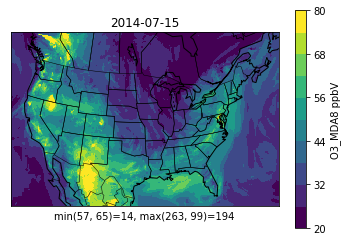

In [17]:
# Run Interactive Animation
if show_timeidx is not None:
    anim.update(show_timeidx)
if interactive_animation:
    anim.interact(start=0)
if save_animation is not None:
    from matplotlib import animation
    frames = 365
    anim.update(0)
    animrender = animation.FuncAnimation(
        anim.figure, anim.update,
        frames=frames, interval=1000, blit=True
    );
    animrender.save(save_animation)


## Box and scatter plots for a selected region

* Change region to one of the options
* Re-run two cells below

In [18]:
print('Options: ')
sorted(regions)

Options: 


['Northeast',
 'Northern Rocky Plains',
 'Northwest',
 'Ohio River Valley',
 'Other',
 'South',
 'Southeast',
 'Southwest',
 'Upper Midwest',
 'West']

In [19]:
# User Choice
region = 'West'
querystr = regions[region]
querystr

"State_Name in ['California', 'Nevada']"

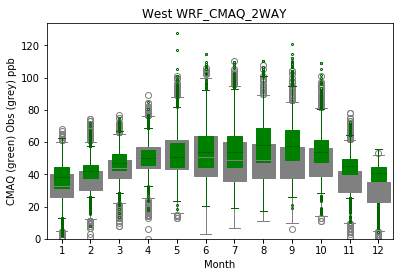

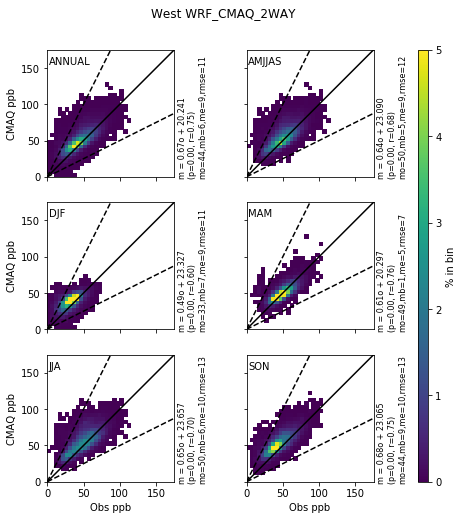

In [20]:
plt.close()
regdf = obsdf.query(querystr)
monboxfig = monthlyboxes(regdf)
# To save the monthly box plot figure for a publication, uncomment below
# monboxfig.savefig('monbox_{}.png'.format(region))
seasscatterfig = seasonalscatter(regdf)
# To save the seasonal scatter plot figure for a publication, uncomment below
# seasscatterfig.savefig('scatter_{}.png'.format(region))

## Time series plot for  a Site

* Subset sites with a custom query
* Display SITEIDPOC options with limited metadata
* Choose one SITEIDPOC

In [21]:
# Initial subset of sites
querystr = 'State_Name == "North Carolina" and County_Name == "Wake"'

In [22]:
groupby = ['State_Name', 'County_Name', 'SITEIDPOC', ]
showcols = groupby + ['Local_Site_Name', 'Land_Use', 'Elevation', 'OBS', 'MOD']
# show all columns
# showcols = obsdf.columns
print('Choose:')
obsdf.query(
    querystr
).filter(showcols).groupby(groupby).max()

Choose:


Local_Site_Name     Land_Use  \
State_Name     County_Name SITEIDPOC                                    
North Carolina Wake        37183001401  Millbrook School  RESIDENTIAL   
                           37183001601     Fuquay-Varina  RESIDENTIAL   

                                        Elevation   OBS        MOD  
State_Name     County_Name SITEIDPOC                                
North Carolina Wake        37183001401      100.0  70.0  71.383583  
                           37183001601      117.0  65.0  81.788666

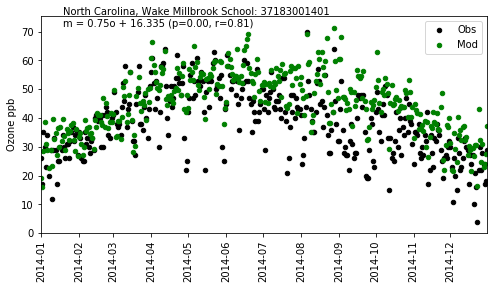

In [23]:
siteid = 37183001401
fig = tssite(siteid)
# fig.savefig('ts_{}.png'.format(siteid))

# Custom Design

* Basic plot building blocks are shown below.
* Build your own

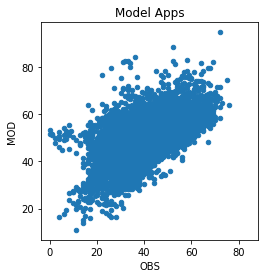

In [24]:
plotdf = obsdf.query('State_Name == "North Carolina"')
ax = plotdf.plot.scatter(x='OBS', y='MOD')
ax.set_title('Model Apps')
ax.axis('square');
# ax.figure.savefig('defaultscatter.png')

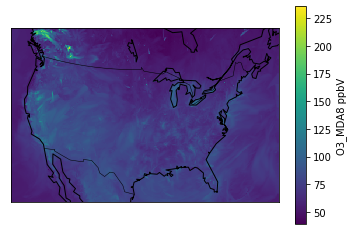

In [25]:
ax = modf.applyAlongDimensions(TSTEP='max').plot(o3key)
# ax.figure.savefig('defaultmap.png')

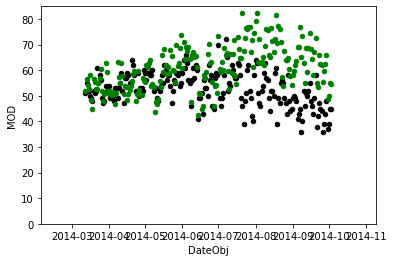

In [26]:
sitedf = obsdf.query('SITEIDPOC == 49035001501')
ax = sitedf.plot.scatter(x='DateObj', y='OBS', c='k')
sitedf.plot.scatter(x='DateObj', y='MOD', c='g', ax=ax)
ax.set_ylim(0, None);
# ax.figure.savefig('defaultts.png')